# Only the mathematical trading strategy for getting the signals

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Dataset

In [13]:
df_5m = pd.read_csv('datasets/btc_5m.csv')
df_5m.index = df_5m.pop('datetime')
df_5m

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
2018-01-01 05:35:00,13600.00,13600.00,13501.01,13554.58,40.528679
2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536
2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614
2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135
...,...,...,...,...,...
2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.164080
2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.051970
2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.395230


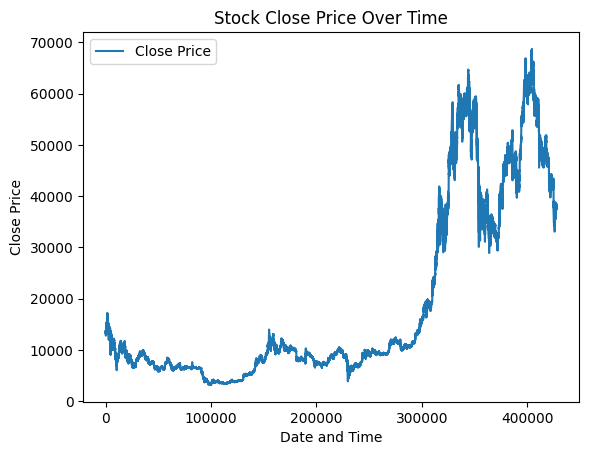

In [8]:
# Visualizing the entire history
plt.plot(df_5m.index, df_5m['close'], label='Close Price')

# Customize the plot
plt.title('Stock Close Price Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Close Price')
plt.legend()

# # Create Candlestick chart
# fig = go.Figure(data=[go.Candlestick(x=df_5m.index,
#                 open=df_5m['open'],
#                 high=df_5m['high'],
#                 low=df_5m['low'],
#                 close=df_5m['close'])])

# # Customize the layout
# fig.update_layout(title='Stock Price Candlestick Chart',
#                   xaxis_title='Date and Time',
#                   yaxis_title='Stock Price',
#                   xaxis_rangeslider_visible=False)

# # Show the plot
# fig.show()

## Strategy

In [18]:
# Using naive predictions for testing
df_5m['next_close'] = df_5m['close'].shift(1)
df_5m = df_5m.dropna()


# RSI column
# Define the period for calculating RSI
rsi_period = 14

# Calculate price changes
df_5m['delta'] = df_5m['close'].diff()

# Calculate gains and losses
gains = df_5m['delta'].where(df_5m['delta'] > 0, 0)
losses = -df_5m['delta'].where(df_5m['delta'] < 0, 0)

# Calculate average gains and losses over the specified period
avg_gain = gains.rolling(window=rsi_period, min_periods=1).mean()
avg_loss = losses.rolling(window=rsi_period, min_periods=1).mean()

# Calculate relative strength (RS)
rs = avg_gain / avg_loss

# Calculate RSI
rsi = 100 - (100 / (1 + rs))

# Add the RSI column to the DataFrame
df_5m['rsi'] = rsi

# Display the DataFrame with the new RSI column
df_5m

C:\Users\sanya\AppData\Local\Temp\ipykernel_10040\912651019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5m['next_close'] = df_5m['close'].shift(1)


,open,high,low,close,volume,next_close,delta,rsi
datetime,,,,,,,,
2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536,13554.58,NaN,NaN
2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614,13556.15,-125.63,0.000000
2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135,13430.52,9.42,6.975194
2018-01-01 05:55:00,13439.94,13550.87,13420.05,13521.12,38.796681,13439.94,81.18,41.899829
2018-01-01 06:00:00,13500.00,13545.37,13479.79,13515.00,24.310215,13521.12,-6.12,40.746571
...,...,...,...,...,...,...,...,...
2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.164080,37950.58,9.29,64.575746
2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.051970,37959.87,-63.46,59.764810
2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.395230,37896.41,31.62,65.351837


1. Get all the present data at time t (open_t,high_t,low_t,close_t,volume_t)
2. Consider some historical data (moving average of previous 14 time steps)
   - If the market has an upward trend, enter or hold
   - If the market has a downward trend, dont enter or sell
3. Remember the support and resistance values
   - If price goes above the resistance, set it as the new support value
   - If the price goes below the support, set it as the new resistance value
4. Set the stop loss and target values
   - If target value hit, buy the stock
   - If stop loss hit, sell
5. Consider the candle stick patterns into this equation
6. Consider the future time step prediction into this, compare it to the risk (drawdown), is the profit worth taking the risk?